https://scikit-learn.org/stable/modules/gaussian_process.html

In [182]:
import time
import itertools
import pandas as pd
import numpy as np
from numpy import sin, sqrt, log, exp

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, RationalQuadratic, DotProduct, Matern, ConstantKernel

from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_openml, load_iris

import scipy.stats as stats

# GPR examples

## GPR with noise-level estimation
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html

In [2]:
rng = np.random.RandomState(0) # Mersenne Twister RNG

In [3]:
N = 20

def f(x):
    return 0.5*sin(3*x)

X = rng.uniform(0,5,N).reshape(-1,1)
y = f(X[:,0]) + rng.normal(0, 0.5, N)

In [4]:
def plot_fit(gp):
    X_ = np.linspace(0, 5, 100)
    y_mean, y_cov = gp.predict(X_.reshape(-1,1), return_cov=True)
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - sqrt(np.diag(y_cov)), y_mean + sqrt(np.diag(y_cov)),
                     alpha=0.5, color='k')
    plt.plot(X_, f(X_), 'r', lw=3, zorder=9)
    plt.scatter(gp.X_train_[:,0], gp.y_train_, 
                c='r', s=50, zorder=10, edgecolors='k')
    plt.title(f"Initial: {kernel}\n"
              f"Optimum: {gp.kernel_}\n"
              f"Log-Marginal-Likelihood: {gp.log_marginal_likelihood(gp.kernel_.theta)}\n")
    plt.tight_layout()

In [5]:
def plot_neglml(gp):
    theta0 = np.logspace(*gp.kernel_.bounds[1],50) # length scale
    theta1 = np.logspace(*gp.kernel_.bounds[2],50) # noise level
    Theta0, Theta1 = np.meshgrid(theta0, theta1)

    LML = np.array([gp.log_marginal_likelihood([gp.kernel_.theta[0], t0, t1])
            for t0,t1 in zip(log(Theta0.flatten()),log(Theta1.flatten()))]).reshape(Theta0.shape)
    E = -LML
    
    vmin, vmax = E.min(), E.max()
    vmax =  min(vmax, vmin*1e5)
    level = np.logspace(np.log10(vmin),np.log10(vmax),100)
    plt.figure()
    plt.contour(Theta0, Theta1, E, levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.plot(exp(gp.kernel_.theta[1]), exp(gp.kernel_.theta[2]), 'rx', markersize=10)
    plt.colorbar()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Length-scale')
    plt.ylabel('Noise-level')
    plt.title("Energy (Negative Log-marginal-likelihood)")
    plt.tight_layout()

In [6]:
theta0_range = [1e-2,1e3] # length scale
theta1_range = [1e-10,1e1] # noise level

First run: high noise level, large length scale

In [7]:
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=theta0_range) \
    + WhiteKernel(noise_level=1, noise_level_bounds=theta1_range)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(X,y)

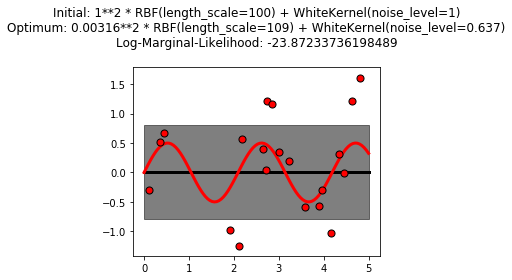

In [8]:
plot_fit(gp)

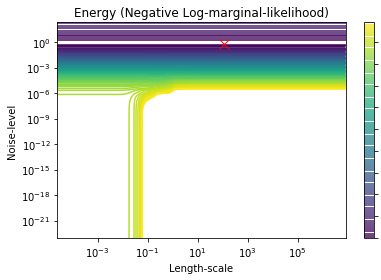

In [9]:
plot_neglml(gp)

Second run: small noise level, short length scale

In [10]:
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(X, y)

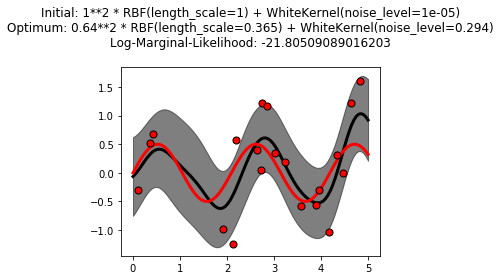

In [11]:
plot_fit(gp)

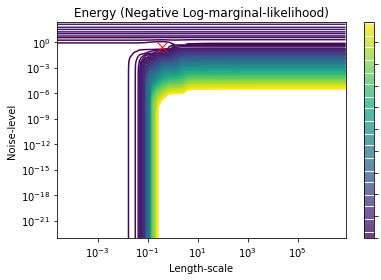

In [12]:
plot_neglml(gp)

## GPR vs KRR
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html

In [13]:
rng = np.random.RandomState(0)

In [14]:
def plot_compare(kr, gpr):
    X_ = np.linspace(0,20,10000).reshape(-1,1)
    lw= 2

    y_kr = kr.predict(X_)
    y_gpr, y_std = gpr.predict(X_, return_std=True)
    
    plt.figure(figsize=(10,5))
    plt.scatter(gpr.X_train_, gpr.y_train_, c='k', label='data')
    plt.plot(X_, sin(X_), color='navy', lw=lw, label='True')
    plt.plot(X_, y_kr, color='turquoise', lw=lw, label=f'KRR ({kr.best_params_})')
    plt.plot(X_, y_gpr, color='darkorange', lw=lw, label=f'GPR ({gpr.kernel_})')
    plt.fill_between(X_[:,0], y_gpr - y_std, y_gpr + y_std, color='darkorange', alpha=0.2)
    plt.xlabel('data')
    plt.ylabel('target')
    plt.xlim(X_.min(), X_.max())
    plt.ylim(-4, 4)
    plt.title('GPR vs KRR')
    plt.legend(loc=4, scatterpoints=1, prop={'size': 8})
    plt.tight_layout()

In [15]:
N = 100
X = 15 * rng.rand(N, 1)
y = sin(X).ravel() + 3 * (0.5 - rng.rand(N))

In [16]:
param_grid = {"alpha": np.logspace(0,-3,4),
              "kernel": [ExpSineSquared(l,p) 
                         for l,p in itertools.product(np.logspace(-2,2,10), np.logspace(0,2,10))]}
kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)

In [17]:
stime = time.time()
kr.fit(X, y)
time_krr_fit = time.time() - stime

In [18]:
gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2,1e1)) \
          + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)

In [19]:
stime = time.time()
gpr.fit(X,y)
time_gpr_fit = time.time() - stime

In [20]:
X_ = np.linspace(0,20,10000).reshape(-1,1)
stime = time.time()
y_kr = kr.predict(X_)
time_krr_predict = time.time() - stime

In [21]:
stime = time.time()
y_gpr = gpr.predict(X_, return_std=False)
time_gpr_predict_wo_std = time.time() - stime

In [22]:
stime = time.time()
y_gpr, y_std = gpr.predict(X_, return_std=True)
time_gpr_predict_with_std = time.time() - stime

In [23]:
print(f"Time for KRR fitting: {time_krr_fit:.3f}")
print(f"Time for GPR fitting: {time_gpr_fit:.3f}")
print(f"Time for KRR prediction: {time_krr_predict:.3f}")
print(f"Time for GPR prediction: {time_gpr_predict_wo_std:.3f}")
print(f"Time for GPR prediction with std: {time_gpr_predict_with_std:.3f}")

Time for KRR fitting: 3.710
Time for GPR fitting: 0.105
Time for KRR prediction: 0.038
Time for GPR prediction: 0.054
Time for GPR prediction with std: 0.037


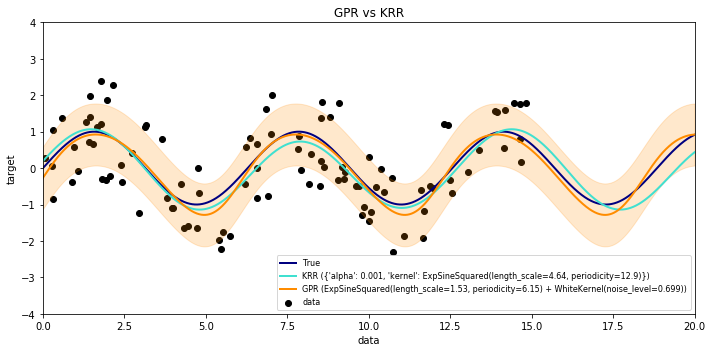

In [24]:
plot_compare(kr, gpr)

### Thoughts

In the original article, it states that: _"GPR correctly identifies the periodicity of the function to be roughly 2*pi (6.28), while KRR chooses the doubled periodicity 4*pi."_ However, this result may be due to the parameter range used in the example. More specifically, the range of periodicity is [1e0, 1e2] for KRR, while it is [1e-2, 1e1] for GPR. <br>
Let us repeat the procedure again with the range of periodicity fixed to [1e0, 1e2].

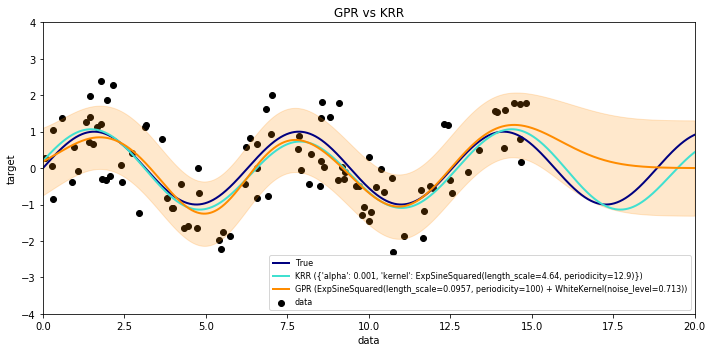

In [25]:
param_grid = {"alpha": np.logspace(0,-3,4),
              "kernel": [ExpSineSquared(l,p) 
                         for l,p in itertools.product(np.logspace(-2,2,10), np.logspace(0,2,10))]}
kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)
kr.fit(X, y)

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e0,1e2)) \
          + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

plot_compare(kr, gpr)

Now GPR severely overestimated the periodicity. <br>
What if the range of periodicity is [1e-2, 1e1].

In [26]:
param_grid = {"alpha": np.logspace(0,-3,4),
              "kernel": [ExpSineSquared(l,p) 
                         for l,p in itertools.product(np.logspace(-2,2,10), np.logspace(-2,1,10))]}
kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)
kr.fit(X, y)

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2,1e1)) \
          + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

plot_compare(kr, gpr)

In this case, KRR seems to fail to capture the true periodicity. However, the quality of grid search relies on the resolution in the parameter space. Let us increase the number of points along the periodicity space.

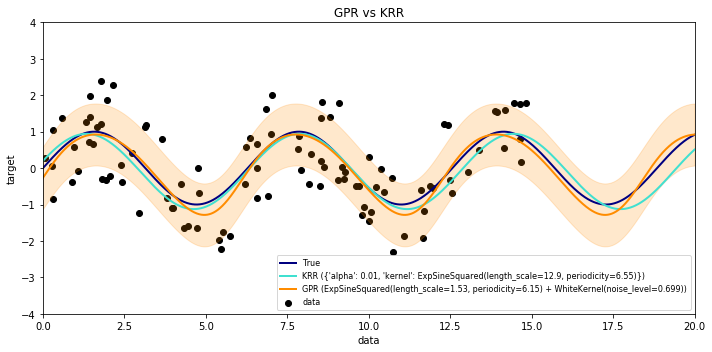

In [27]:
param_grid = {"alpha": np.logspace(0,-3,4),
              "kernel": [ExpSineSquared(l,p) 
                         for l,p in itertools.product(np.logspace(-2,2,10), np.logspace(-2,1,50))]}
kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)
kr.fit(X, y)
y_kr = kr.predict(X_)

lw= 2
plt.figure(figsize=(10,5))
plt.scatter(X, y, c='k', label='data')
plt.plot(X_, sin(X_), color='navy', lw=lw, label='True')
plt.plot(X_, y_kr, color='turquoise', lw=lw, label=f'KRR ({kr.best_params_})')
plt.plot(X_, y_gpr, color='darkorange', lw=lw, label=f'GPR ({gpr.kernel_})')
plt.fill_between(X_[:,0], y_gpr - y_std, y_gpr + y_std, color='darkorange', alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(X_.min(), X_.max())
plt.ylim(-4, 4)
plt.title('GPR vs KRR')
plt.legend(loc=4, scatterpoints=1, prop={'size': 8})
plt.tight_layout()

In this case, KRR successfully captures the periodicity, even though the process of grid search is time consuming.

To sum up, GPR is not as powerful as demonstrated in the original example. Also, the bounds of hyperparameters and the resolution of grids are also parameters we have to choose manually.

## GPR on Mauna Loa CO2 data
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html

In [28]:
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    df = pd.DataFrame(ml_data.data[:,:2], columns=['year','month'])
    df['ppmv'] = ml_data.target
    df = df.groupby(['year','month']).agg({'ppmv':'mean'}).reset_index()
    df['t'] = df['year'] + (df['month']-1)/12
    df.drop(columns=['year','month'], inplace=True)
    
    return df

In [29]:
df = load_mauna_loa_atmospheric_co2()

In [30]:
# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0) # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) * ExpSineSquared(length_scale=1.3, periodicity=1.0) # seasonal component
k3 = 0.66**2 * RationalQuadratic(length_scale=1.2, alpha=0.78) # medium term irregularity
k4 = 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.19**2) # noise terms
kernel_gpml = k1 + k2 + k3 + k4

In [31]:
gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0, optimizer=None, normalize_y=True)
gp.fit(df['t'].values.reshape(-1,1), df['ppmv'])

print(f"GPML kernel: {gp.kernel_}")
print(f"Log-marginal-likelihood: {gp.log_marginal_likelihood_value_:.3f}")

GPML kernel: 66**2 * RBF(length_scale=67) + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.0361)
Log-marginal-likelihood: -117.023


In [32]:
# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0) # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed") # seasonal component
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0) # medium term irregularity
k4 = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-3, np.inf)) # noise terms
kernel = k1 + k2 + k3 + k4

In [33]:
gp = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True)
gp.fit(df['t'].values.reshape(-1,1), df['ppmv'])

print(f"Learned kernel: {gp.kernel_}")
print(f"Log-marginal-likelihood: {gp.log_marginal_likelihood_value_:.3f}")

Learned kernel: 44.8**2 * RBF(length_scale=51.6) + 2.64**2 * RBF(length_scale=91.5) * ExpSineSquared(length_scale=1.48, periodicity=1) + 0.536**2 * RationalQuadratic(alpha=2.89, length_scale=0.968) + 0.188**2 * RBF(length_scale=0.122) + WhiteKernel(noise_level=0.0367)
Log-marginal-likelihood: -115.050


In [34]:
X_ = np.linspace(df['t'].min(), df['t'].max()+30, 1000).reshape(-1,1)
y_pred, y_std = gp.predict(X_, return_std=True)

plt.figure(figsize=(10,5))
plt.scatter(df['t'], df['ppmv'], c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:,0], y_pred - y_std, y_pred + y_std, alpha=0.5, color='k')
plt.xlim(X_.min(),X_.max())
plt.xlabel("Year")
plt.ylabel(f"CO$_2$ in ppm")
plt.title(f"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()

### Thoughts

The prediction is based on average ppmv per month. What if we train the model with the original measurements (average per week)?

In [35]:
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    df = pd.DataFrame(ml_data.data, columns=ml_data.feature_names)
    df['ppmv'] = ml_data.target
    df['date'] = pd.to_datetime(df[['year','month','day']])
    df['t'] = df['year'] + (df['month'] + df['day'] / df['date'].dt.daysinmonth - 1)/12
    return df[['t','ppmv']]

In [36]:
df = load_mauna_loa_atmospheric_co2()

In [37]:
# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0) # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed") # seasonal component
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0) # medium term irregularity
k4 = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-3, np.inf)) # noise terms
kernel = k1 + k2 + k3 + k4

In [38]:
gp = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True)
gp.fit(df['t'].values.reshape(-1,1), df['ppmv'])

print(f"Learned kernel: {gp.kernel_}")
print(f"Log-marginal-likelihood: {gp.log_marginal_likelihood_value_:.3f}")

Learned kernel: 48.3**2 * RBF(length_scale=54.4) + 2.54**2 * RBF(length_scale=133) * ExpSineSquared(length_scale=1.32, periodicity=1) + 6.85**2 * RationalQuadratic(alpha=0.000815, length_scale=4.92) + 0.34**2 * RBF(length_scale=0.012) + WhiteKernel(noise_level=0.00102)
Log-marginal-likelihood: -883.784


In [39]:
X_2 = np.linspace(df['t'].min(), df['t'].max()+30, 1000).reshape(-1,1)
y_pred2, y_std2 = gp.predict(X_2, return_std=True)

fig, axes = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [2,1]})
ax = axes[0]
ax.scatter(df['t'], df['ppmv'], c='k')
ax.plot(X_, y_pred, color='b', label='monthly')
ax.fill_between(X_[:,0], y_pred - y_std, y_pred + y_std, alpha=0.5, color='b')
ax.plot(X_2, y_pred2, color='orange', label='weekly')
ax.fill_between(X_2[:,0], y_pred2 - y_std2, y_pred2 + y_std2, alpha=0.4, color='orange')
ax.set_xlim(X_.min(),X_.max())
ax.set_xlabel("Year")
ax.set_ylabel(f"CO$_2$ in ppm")
ax.legend(loc=4)

ax = axes[1]
ax.scatter(df['t'], df['ppmv'], c='k')
ax.plot(X_, y_pred, color='b', label='monthly')
ax.fill_between(X_[:,0], y_pred - y_std, y_pred + y_std, alpha=0.5, color='b')
ax.plot(X_2, y_pred2, color='orange', label='weekly')
ax.fill_between(X_2[:,0], y_pred2 - y_std2, y_pred2 + y_std2, alpha=0.4, color='orange')
ax.set_xlim(2020,X_.max())
ax.set_xlabel("Year")
ax.set_ylabel(f"CO$_2$ in ppm")
ax.legend(loc=4)

plt.suptitle(f"Atmospheric CO$_2$ concentration at Mauna Loa")
#plt.tight_layout()

Text(0.5, 0.98, 'Atmospheric CO$_2$ concentration at Mauna Loa')

The difference between both predictions are within one standard deviation. They are quite close.

# GPC examples

## Probabilistic predictions with GPC
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc.html

In [40]:
rng = np.random.RandomState(0)

N = 100
Ntrain = 50
X = rng.uniform(0,5,N).reshape(-1,1)
y = (X > 2.5).astype(int).flatten()

In [41]:
gp_fix = GaussianProcessClassifier(kernel=1.0*RBF(length_scale=1.0), optimizer=None)
gp_fix.fit(X[:Ntrain], y[:Ntrain])

gp_opt = GaussianProcessClassifier(kernel=1.0*RBF(length_scale=1.0))
gp_opt.fit(X[:Ntrain], y[:Ntrain])

print(f"Log Marginal Likelihood (initial): {gp_fix.log_marginal_likelihood_value_:.3f}")
print(f"Log Marginal Likelihood (optimized): {gp_opt.log_marginal_likelihood_value_:.3f}")

print(f"Accuracy: "
      f"{accuracy_score(y[:Ntrain], gp_fix.predict(X[:Ntrain])):.3f} (initial) "
      f"{accuracy_score(y[:Ntrain], gp_opt.predict(X[:Ntrain])):.3f} (optimized)")
print(f"Log-loss: "
      f"{log_loss(y[:Ntrain], gp_fix.predict_proba(X[:Ntrain])[:,1]):.3f} (initial) "
      f"{log_loss(y[:Ntrain], gp_opt.predict_proba(X[:Ntrain])[:,1]):.3f} (optimized)")

Log Marginal Likelihood (initial): -17.598
Log Marginal Likelihood (optimized): -3.875
Accuracy: 1.000 (initial) 1.000 (optimized)
Log-loss: 0.214 (initial) 0.319 (optimized)


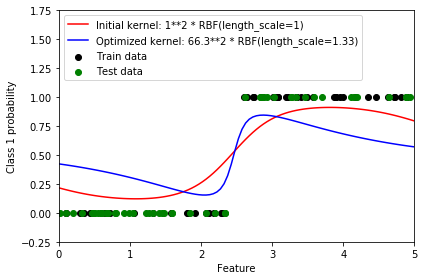

In [42]:
plt.figure()
plt.scatter(X[:Ntrain, 0], y[:Ntrain], c='k', label='Train data')
plt.scatter(X[Ntrain:, 0], y[Ntrain:], c='g', label='Test data')

X_ = np.linspace(0, 5, 100)
plt.plot(X_, gp_fix.predict_proba(X_.reshape(-1,1))[:,1], 'r', label=f'Initial kernel: {gp_fix.kernel_}')
plt.plot(X_, gp_opt.predict_proba(X_.reshape(-1,1))[:,1], 'b', label=f'Optimized kernel: {gp_opt.kernel_}')
plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0,5)
plt.ylim(-0.25, 1.75)
plt.legend(loc=2)
plt.tight_layout()

In [43]:
plt.figure()
theta0 = np.logspace(0, 8, 30)
theta1 = np.logspace(-1, 1, 29)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = np.array([gp_opt.log_marginal_likelihood(
        [t0, t1]) for t0,t1 in zip(log(Theta0.flatten()), log(Theta1.flatten()))]).reshape(Theta0.shape)

plt.plot(*exp(gp_fix.kernel_.theta), 'ro', zorder=10)
plt.plot(*exp(gp_opt.kernel_.theta), 'bo', zorder=10)
plt.pcolor(Theta0, Theta1, LML)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlabel('Magnitude')
plt.ylabel('Length-scale')
plt.title('Log-marginal-likelihood')
plt.tight_layout()

### Thoughts

Test data is meaningless in this example.

(To be continued)

## GPC on XOR dataset
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc_xor.html

In [44]:
rng = np.random.RandomState(0)
N = 200
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
X = rng.randn(N, 2)
y = np.logical_xor(X[:,0] > 0, X[:,1] > 0)

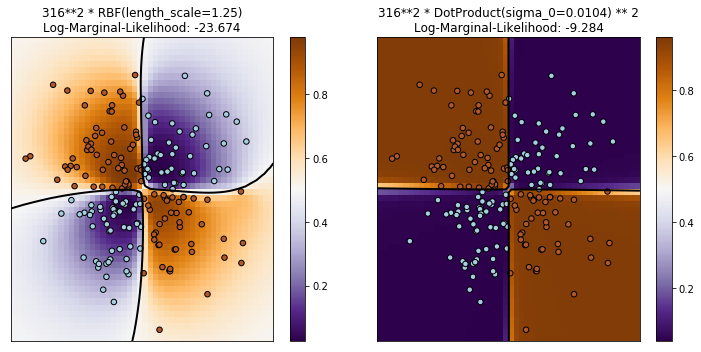

In [45]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
kernels = [1.0*RBF(length_scale=1.0), 1.0*DotProduct(sigma_0=1.0)**2]

for i,kernel in enumerate(kernels):
    gp = GaussianProcessClassifier(kernel=kernel, warm_start=True)
    gp.fit(X,y)
    
    Z = gp.predict_proba(np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)]))[:,1].reshape(xx.shape)
    
    ax = axes[i]
    image = ax.imshow(Z, interpolation='nearest', 
                      extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                      aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = ax.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors=['k'])
    ax.scatter(X[:, 0], X[:,1], s=30, c=y, cmap=plt.cm.Paired, edgecolor='k')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(image, ax=ax)
    ax.set_title(f"{gp.kernel_}\n"
                 f"Log-Marginal-Likelihood: {gp.log_marginal_likelihood_value_:.3f}", fontsize=12)

plt.tight_layout()

### Thoughts

Suppose the X stores true values, let us generate y using contaminated X. <br>
Also, we measure the performance using an extra validation set.

In [46]:
X_noisy = X + 0.2*rng.randn(N, 2)
y_noisy = np.logical_xor(X_noisy[:,0] > 0, X_noisy[:,1] > 0)

X_val = rng.randn(200, 2)
y_val = np.logical_xor(X_val[:,0] > 0, X_val[:,1] > 0)

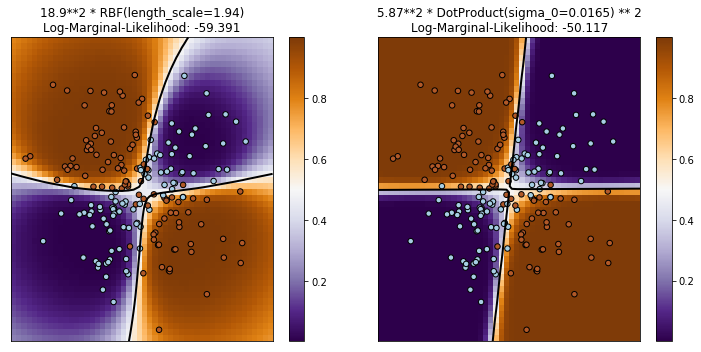

In [47]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
kernels = [1.0*RBF(length_scale=1.0), 1.0*DotProduct(sigma_0=1.0)**2]
y_pred = []
for i,kernel in enumerate(kernels):
    gp = GaussianProcessClassifier(kernel=kernel, warm_start=True)
    gp.fit(X,y_noisy)
    
    y_pred.append(gp.predict(X_val))
    Z = gp.predict_proba(np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)]))[:,1].reshape(xx.shape)
    
    ax = axes[i]
    image = ax.imshow(Z, interpolation='nearest', 
                      extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                      aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = ax.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors=['k'])
    ax.scatter(X[:, 0], X[:,1], s=30, c=y_noisy, cmap=plt.cm.Paired, edgecolor='k')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(image, ax=ax)
    ax.set_title(f"{gp.kernel_}\n"
                 f"Log-Marginal-Likelihood: {gp.log_marginal_likelihood_value_:.3f}", fontsize=12)

plt.tight_layout()

In [48]:
print(f"Target error due to noise: {(y!=y_noisy).mean():.2%}")
print(f"Accuracy using RBF: {(y_pred[0]==y_val).mean():.2%}")
print(f"Accuracy using DP: {(y_pred[1]==y_val).mean():.2%}")

Target error due to noise: 8.00%
Accuracy using RBF: 91.00%
Accuracy using DP: 96.50%


In this situation, the DotProduct kernel is more robust.

## GPC on iris dataset
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc_iris.html

isotropic RBF vs anisotropic RBF

In [76]:
iris = load_iris()
type(iris)

sklearn.utils.Bunch

In [77]:
X = iris.data[:,:2]
y = iris.target

In [78]:
xlim = [X[:,0].min()-1, X[:,0].max()+1]
ylim = [X[:,1].min()-1, X[:,1].max()+1]
h = .02
xx, yy = np.meshgrid(np.arange(*xlim, h),
                     np.arange(*ylim, h))

In [90]:
kernel = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)
kernel = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)

In [101]:
titles = ['Isotropic RBF', 'Anisotropic RBF']
models = [gpc_rbf_isotropic, gpc_rbf_anisotropic]
plt.figure(figsize=(10,5))
for i,(clf,title) in enumerate(zip(models, titles)):
    plt.subplot(1, 2, i+1)
    Z = clf.predict_proba(np.c_[xx.flatten(), yy.flatten()]).reshape(*xx.shape, 3)
    
    plt.imshow(Z, extent=(*xlim, *ylim), origin='lower', aspect='auto')
    plt.scatter(X[:,0], X[:,1], c=np.array(['r', 'g', 'b'])[y], edgecolors='k')
    
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{title}, LML: {clf.log_marginal_likelihood_value_:.3f}")

### Thoughts

Compare the difference.

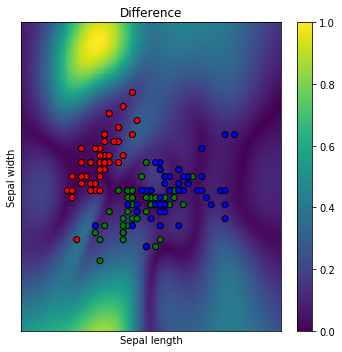

In [100]:
models = [gpc_rbf_isotropic, gpc_rbf_anisotropic]
Zs = []
for clf in models:
    Zs.append(clf.predict_proba(np.c_[xx.flatten(), yy.flatten()]).reshape(*xx.shape, 3))

diff = Zs[1] - Zs[0]
rms = np.sqrt((diff**2).sum(2))

plt.figure(figsize=(5,5))
plt.imshow(rms, extent=(*xlim, *ylim), origin='lower', aspect='auto')
plt.scatter(X[:,0], X[:,1], c=np.array(['r', 'g', 'b'])[y], edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title("Difference")
plt.tight_layout()

#### Cross Validation

In [111]:
param_grid = {'kernel': [1.0*RBF([1.0]), 1.0*RBF([1.0,1.0])]}
grid = GridSearchCV(GaussianProcessClassifier(), param_grid=param_grid, cv=5)
grid.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianProcessClassifier(copy_X_train=True, kernel=None,
                                                 max_iter_predict=100,
                                                 multi_class='one_vs_rest',
                                                 n_jobs=None,
                                                 n_restarts_optimizer=0,
                                                 optimizer='fmin_l_bfgs_b',
                                                 random_state=None,
                                                 warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'kernel': [1**2 * RBF(length_scale=1),
                                    1**2 * RBF(length_scale=[1, 1])]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [112]:
grid.best_params_

{'kernel': 1**2 * RBF(length_scale=[1, 1])}

In [113]:
grid.cv_results_

{'mean_fit_time': array([0.18730383, 0.2550703 ]),
 'std_fit_time': array([0.01520231, 0.03143135]),
 'mean_score_time': array([0.00192833, 0.00196419]),
 'std_score_time': array([3.59419468e-05, 2.64825416e-05]),
 'param_kernel': masked_array(data=[1**2 * RBF(length_scale=1),
                    1**2 * RBF(length_scale=[1, 1])],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'kernel': 1**2 * RBF(length_scale=1)},
  {'kernel': 1**2 * RBF(length_scale=[1, 1])}],
 'split0_test_score': array([0.73333333, 0.73333333]),
 'split1_test_score': array([0.86666667, 0.86666667]),
 'split2_test_score': array([0.76666667, 0.76666667]),
 'split3_test_score': array([0.83333333, 0.83333333]),
 'split4_test_score': array([0.83333333, 0.9       ]),
 'mean_test_score': array([0.80666667, 0.82      ]),
 'std_test_score': array([0.04898979, 0.06182412]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [120]:
score = np.zeros((5,2))
for i in range(5):
    score[i] = grid.cv_results_[f'split{i}_test_score']
stats.ttest_rel(score[:,1],score[:,0])

Ttest_relResult(statistic=1.0, pvalue=0.373900966300059)

The performance difference between the two types of kernel is not statistically significant.

# Kernel
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html

In [157]:
def f(x):
    return sin((x - 2.5) ** 2)

rng = np.random.RandomState(4)
X = rng.uniform(0, 5, 10).reshape(-1, 1)
y = f(X).flatten()

In [158]:
gp = GaussianProcessRegressor()

In [193]:
def plot_kernel(kernel, X, y):
    def sub(gp, ax):    
        X_ = np.linspace(*xlim, 1000)
        y_mean, y_std = gp.predict(X_.reshape(-1,1), return_std=True)
        ax.plot(X_, y_mean, 'k', lw=3, zorder=9, label='Estimate')
        ax.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2, color='k')
        y_samples = gp.sample_y(X_.reshape(-1,1), 10)
        ax.plot(X_, y_samples, lw=1)
        
        if hasattr(gp, 'X_train_'):
            ax.scatter(gp.X_train_, gp.y_train_, c='r', s=50, zorder=10, edgecolors='k')
            y_true = f(X_).flatten()
            ax.plot(X_, y_true, 'r', lw=3, zorder=8, label='True')
            ax.legend(loc=4)
            
        ax.set_xlim(xlim)
        ax.set_ylim([-3,3])
        if not hasattr(gp, 'X_train_'):
            ax.set_title(f"Prior (kernel: {gp.kernel})")
        else:
            ax.set_title(f"Posterior (kernel: {gp.kernel_})\n"
                         f"Log-Likelihood: {gp.log_marginal_likelihood_value_:.3f}")
            
    gp = GaussianProcessRegressor(kernel=kernel)
    fig, axes = plt.subplots(1,2, figsize=(15,5), sharex=True, sharey=True)
    xlim = [0,5]

    sub(gp, axes[0])
    gp.fit(X, y)
    sub(gp, axes[1])
    plt.tight_layout()

## RBF

In [194]:
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
plot_kernel(kernel, X, y)

### Without length scale bounds

In [195]:
kernel = 1.0 * RBF(length_scale=1.0)
plot_kernel(kernel, X, y)

## Matern

Important $\nu$: [0.5, 1.5, 2.5, $\infty$]. $\infty$ case is equivalent to RBF.

### $\nu=0.5$

/media/hdd/envs/tf/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


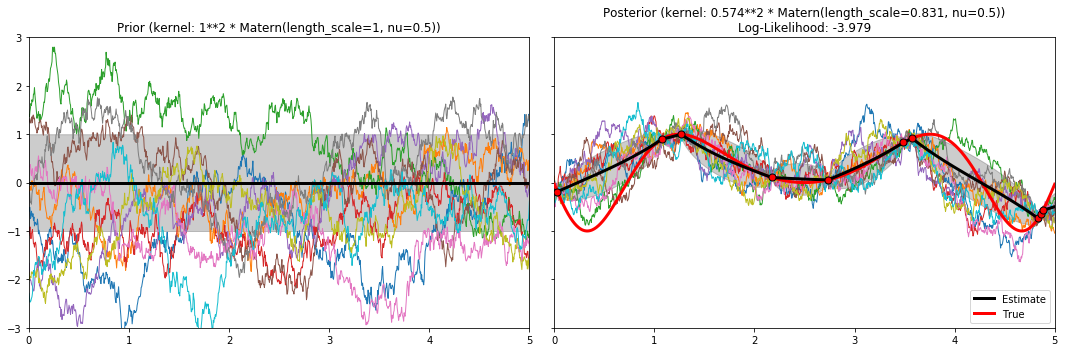

In [196]:
kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=0.5)
plot_kernel(kernel, X, y)

### $\nu=1.5$

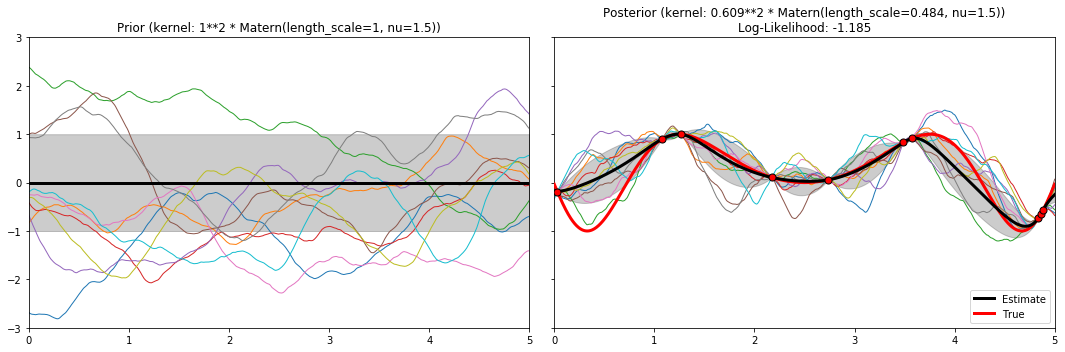

In [197]:
kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
plot_kernel(kernel, X, y)

### $\nu=2.5$

In [198]:
kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=2.5)
plot_kernel(kernel, X, y)

## Rational quadratic

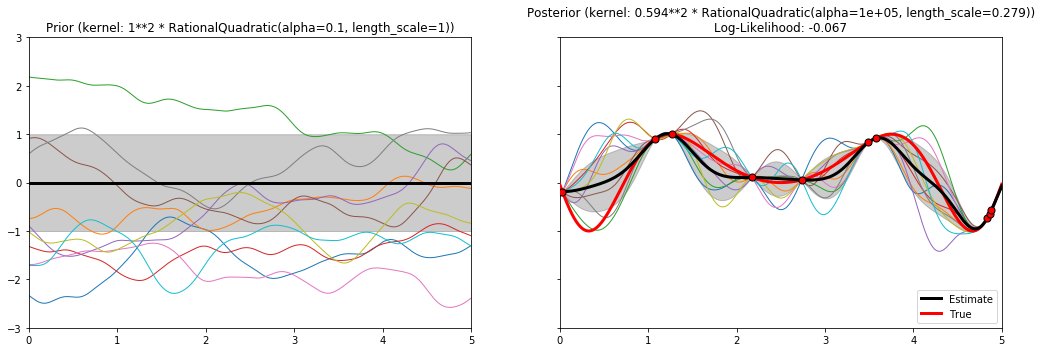

In [199]:
kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
plot_kernel(kernel, X, y)

## Exp-Sine-Squared

/media/hdd/envs/tf/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


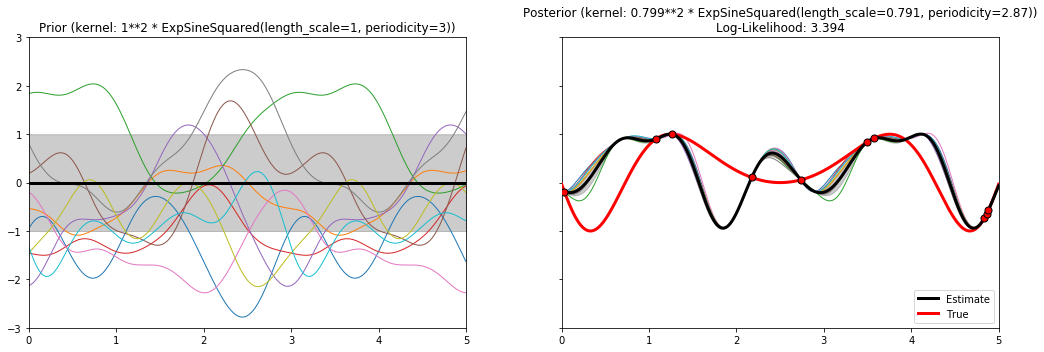

In [200]:
kernel = 1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                              length_scale_bounds=(0.1, 10),
                              periodicity_bounds=(1.0, 10))
plot_kernel(kernel, X, y)

## Dot-Product

/media/hdd/envs/tf/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-13107200.,    -28672.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 158, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)
/media/hdd/envs/tf/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


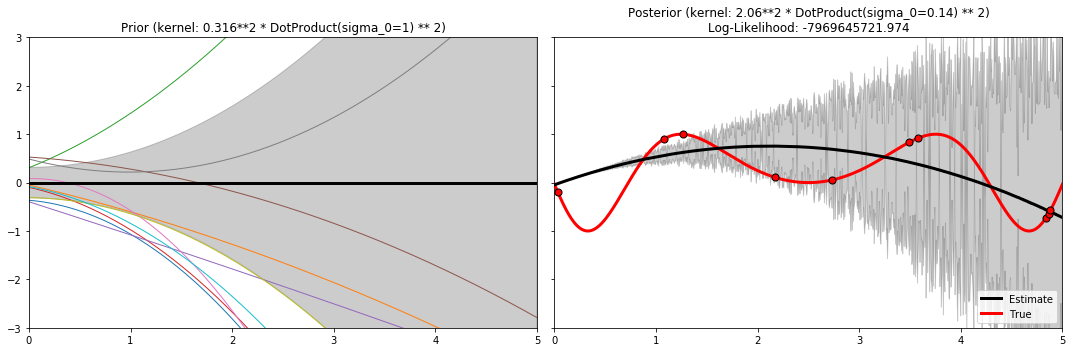

In [205]:
kernel = ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1, sigma_0_bounds=(0.1, 10)) ** 2)
plot_kernel(kernel, X, y)

### Without bounds

/media/hdd/envs/tf/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


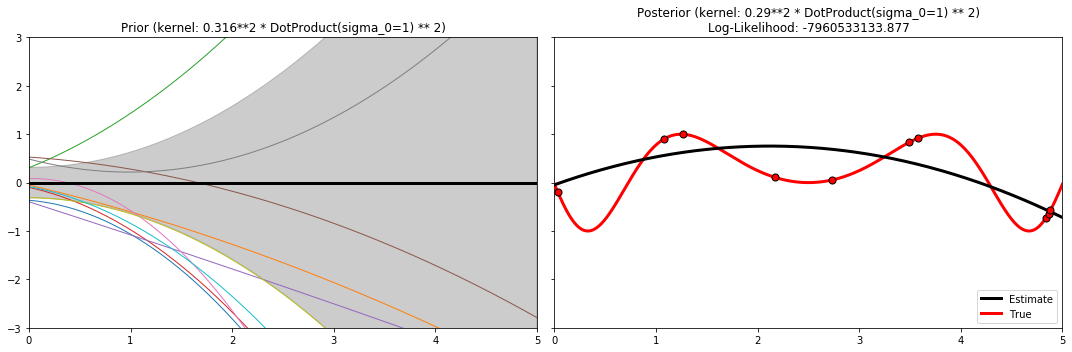

In [211]:
kernel = 0.1 * (DotProduct(sigma_0=1) ** 2)
plot_kernel(kernel, X, y)